# Exploring the feature space of human knowledge about common objects

## Introduction


Human mind is able to process things and moments vividly perceived in daily life into abstract concepts and crystalized knowledge. Understanding the nature of human knowledge has been a central question in psychology, and it may also have theoretical and practical implications for the field of artificial intelligence. One key characteristic of human knowledge is its structured nature, which allows new pieces of information (e.g., a plant that a person sees for the first time) to be learned efficiently by integrating it *into* existing categories (Orchidaceae -> Phragmipedium). Meanwhile, those categories are built upon concrete information that has been experienced by the person over time (e.g., different orchid species).
<div>
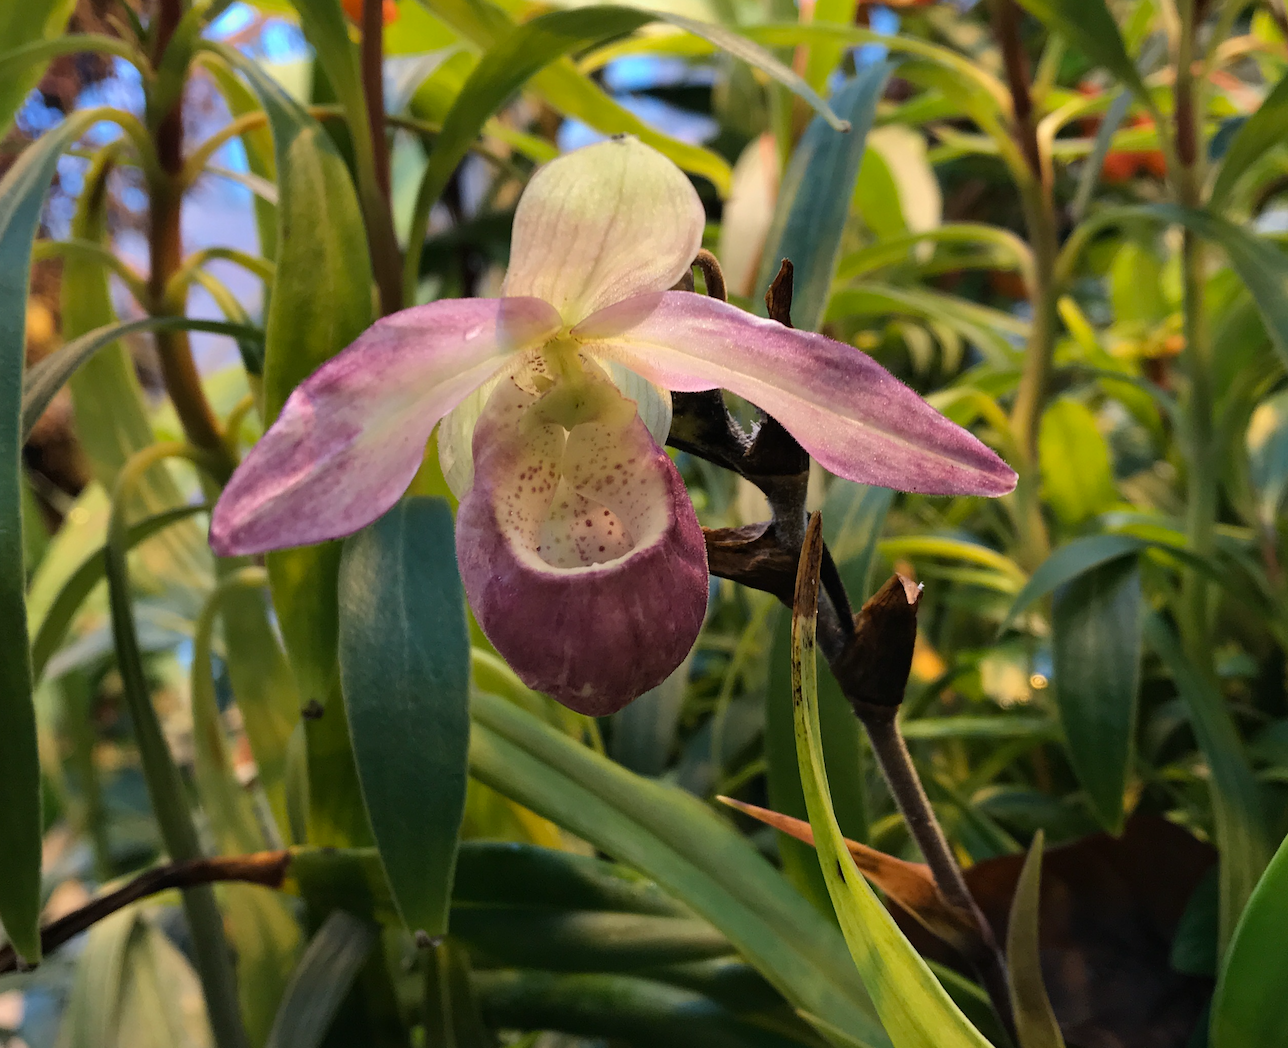
</div>


Knowledge can be conveniently extracted from large corpus of texts and subsequently used for trainning word embeddings in an unsupervised manner, but it remains a challenge to fully understand the meaning of the embedding space. Another approach, which is more labor-intensive but has better explainability, is to obtain collective descriptions of concepts from human participants. This paradigm is able to curate structured dataset of concepts with a list of explainable attributes that belongs to each individual concept. Efforts in this area include the works from the McRae Group (https://sites.google.com/site/kenmcraelab/contact) and, more recently, the works from the research group that I'm currently working in (see: https://link.springer.com/article/10.3758/s13421-020-01130-5). 


Specifically, in the study from our group, 566 participants were recruited on the Amazon Mechanical Turk platform to perform a description task on 995 concepts of objects. For each object, participants were shown an exemplar image of the object and prompted to describe 5 unique features using drop-down menus and text boxes. The responses from all participants were then aggregated by objects, and this lead to **5559 unique descriptions** of the features across all objects. **In other words, each object can be viewed as located somewhere in a 5559-dimension feature space.** However, since each object has relatively limited number of features, the feature space is inevitably very sparse, meaning that the elements in an object's feature vector would be mostly zero. Therefore, it would be interesting to ask 1) whether these objects can be represented in a more **compact**, low-dimension space, 2) how to find such low-dimension space, and 3) whether some information in the original high-dimension space can be preserved (or even strengthened) in the low-dimension space.
<div>
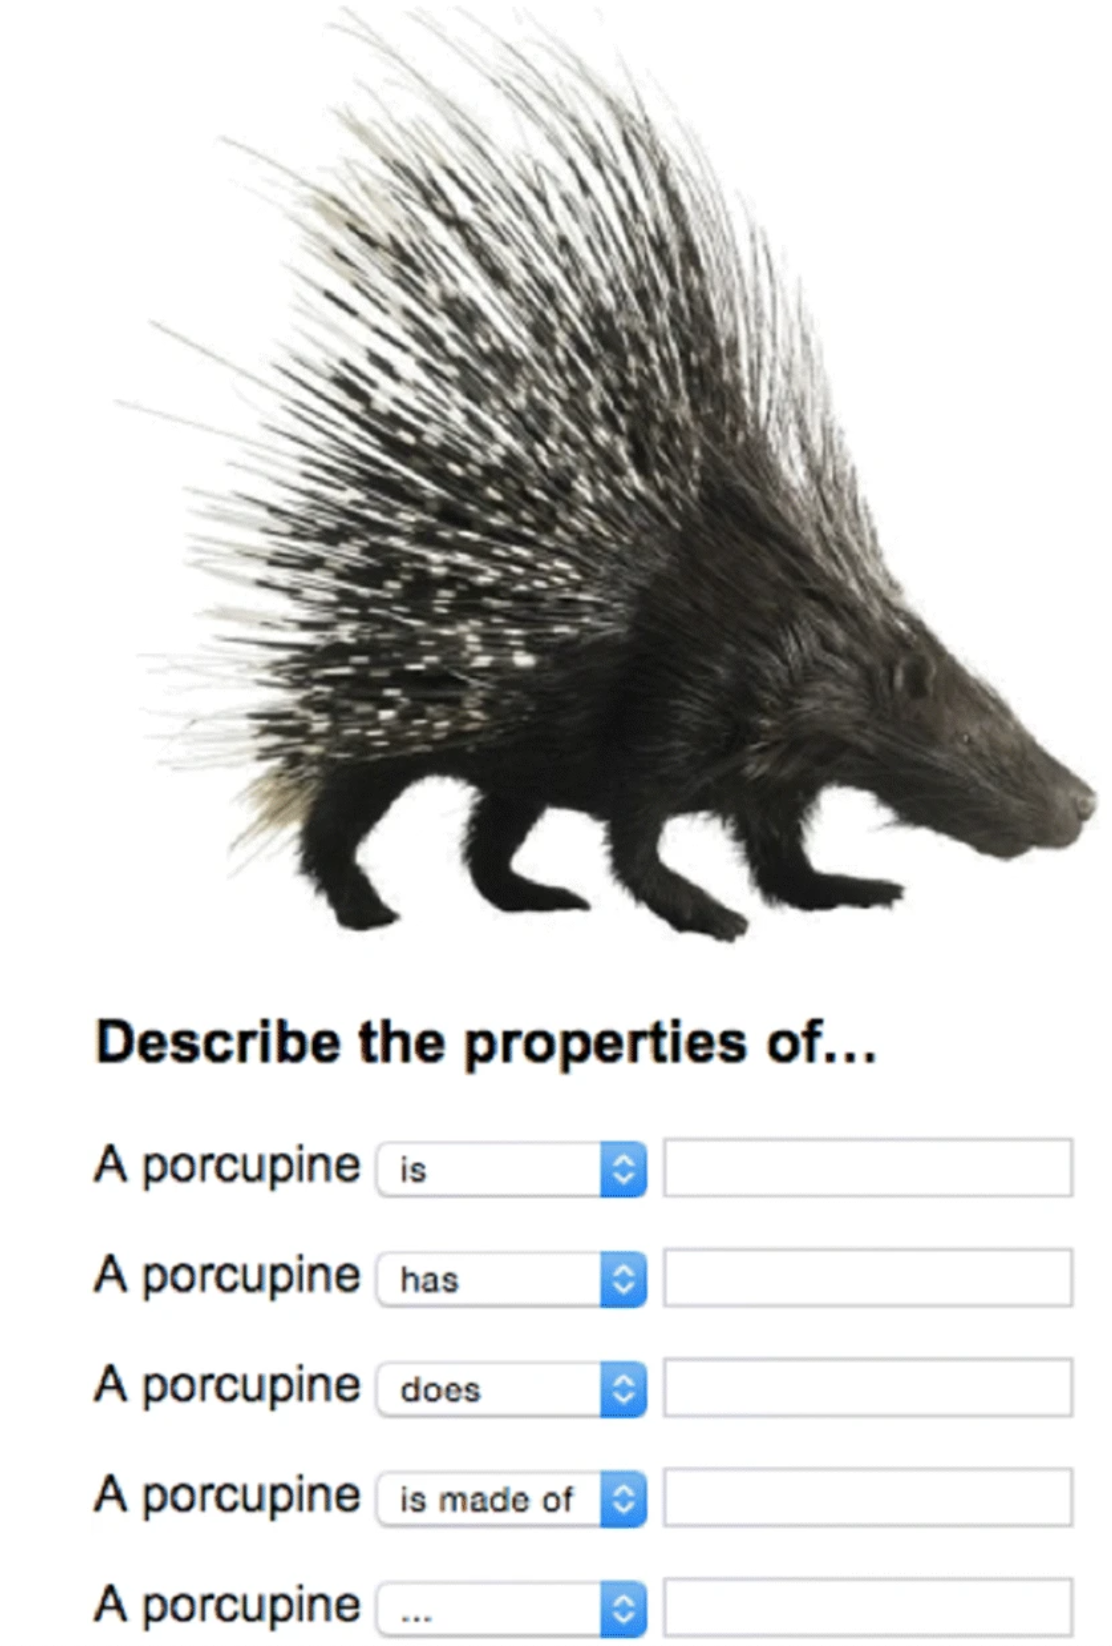
</div>


The dataset is publicly available on Open Science Foundation website (https://osf.io/49zej/). Note that the dataset also includes object images, which may be of interest to some of the readers whose expertise involve human/computer vision. For the current analysis, we will be looking only at the semantic features.





.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df_all=pd.read_csv('conceptFreqMatrix.csv')
df_all.head(2)


ID      concept             category     domain  is_made_of_metal  \
0   1  accent lamp            furniture  nonliving                 0   
1   2    accordion  musical instruments  nonliving                 4   

   is_made_of_wood  is_made_of_plastic  is_useful  has_a_handle  is_small  \
0                0                   1          3             0         5   
1                2                   2          0             0         0   

   ...  does_get_messy  does_film  does_cool_a_person  allows_for_hiding  \
0  ...               0          0                   0                  0   
1  ...               0          0                   0                  0   

   does_cool_a_room  does_keep_hands_clean  does_hold_chess_pieces  \
0                 0                      0                       0   
1                 0                      0                       0   

   does_come_from_birds  does_cause_allergies  does_keep_order  
0                     0                     0                0  
1                     0                     0                0  

[2 rows x 5563 columns]

-----------------

get all feature names

In [4]:
featnames=df_all.columns.to_list()
featnames=featnames[4:]
print('number of rows: {}'.format( df_all.shape[0] ))
print('number of object concepts: {}'.
      format( len( df_all['concept'].unique() ) ))
print('number of categories: {}'.
      format( len(df_all['category'].unique()) ))
print('number of domains: {}'.
      format( len(df_all['domain'].unique()) ))

number of rows: 994
number of object concepts: 994
number of categories: 29
number of domains: 2


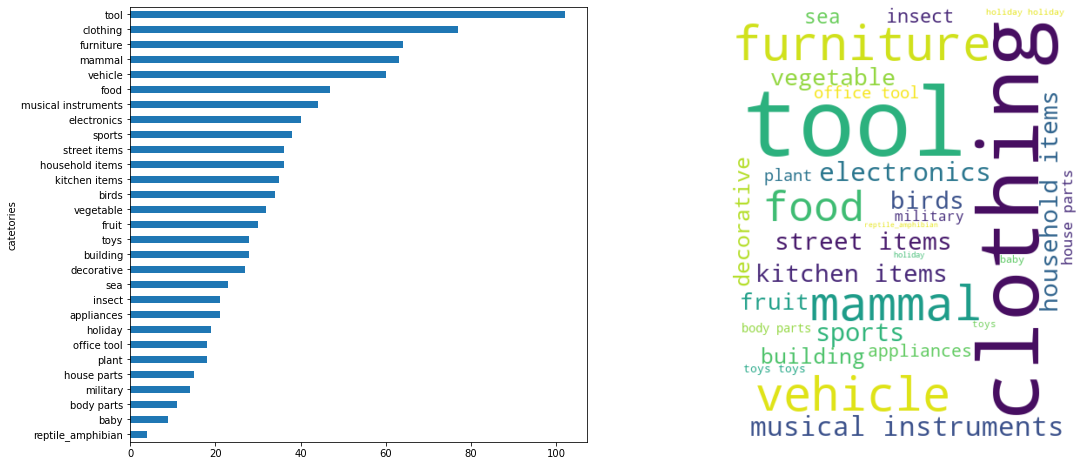

In [2]:
category_count=df_all.groupby('category')['category'].count()

fig,Ax = plt.subplots(1,2)

tmp=category_count.sort_values(ascending=True)
tmp.plot.barh(ax=Ax[0])
plt.setp(Ax[0],ylabel='catetories')

tmpstr=''
for i in df_all['category']:
    tmpstr=tmpstr + ' ' + i.replace(' ', '-')
wcloud=WordCloud(background_color='white',width=400,height=500)
wcloud.generate(tmpstr)
Ax[1].imshow(wcloud, interpolation='bilinear')
Ax[1].axis('off')

fig.set_figwidth(18) # set width
fig.set_figheight(8) # set height

### Let's take a look at the distribution of features across objects

[Text(0.5, 0, 'number of features an object has'), Text(0, 0.5, 'frequency')]

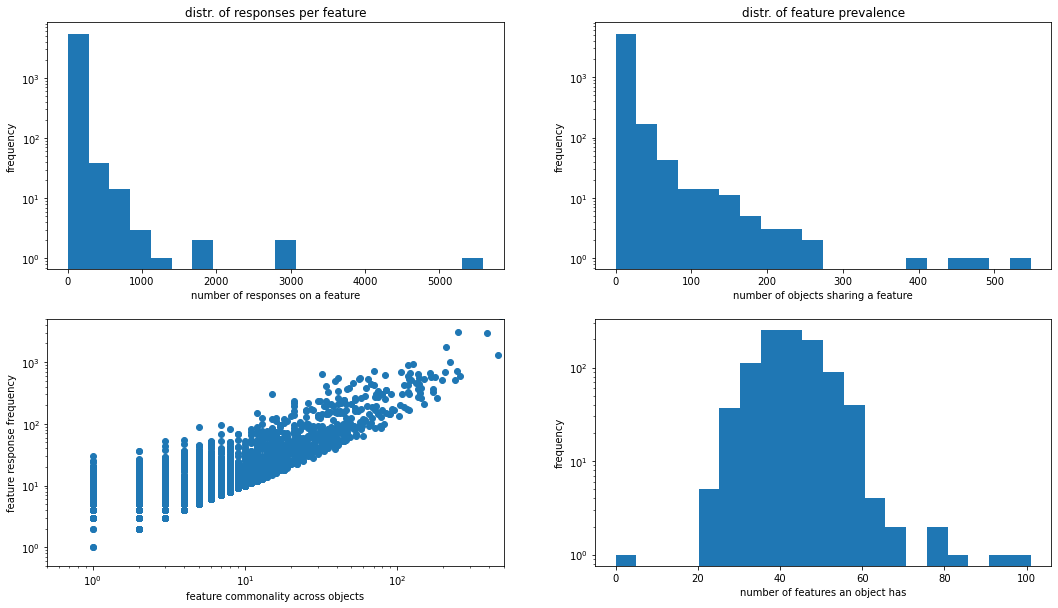

In [3]:
g,Ax=plt.subplots(2,2)
g.set_size_inches(18,10)

tmp=df_all.iloc[:,4:].sum(axis=0)
Ax[0,0].hist(tmp,log=True,bins=20)
Ax[0,0].set_title('distr. of responses per feature')
plt.setp(Ax[0,0],xlabel='number of responses on a feature',
         ylabel='frequency')

tmp=(df_all.iloc[:,4:]!=0).sum(axis=0)
Ax[0,1].hist(tmp,log=True,bins=20)
Ax[0,1].set_title('distr. of feature prevalence')
plt.setp(Ax[0,1],xlabel='number of objects sharing a feature',
         ylabel='frequency')

Ax[1,0].scatter(x=(df_all.iloc[:,4:]!=0).sum(axis=0),y=df_all.iloc[:,4:].sum(axis=0))
Ax[1,0].set_xscale('log'),Ax[1,0].set_yscale('log')
plt.setp(Ax[1,0],xlabel='feature commonality across objects',
         ylabel='feature response frequency')
Ax[1,0].set_xlim([.5,500]),Ax[1,0].set_ylim([.5,5000])

tmp=(df_all.iloc[:,4:]!=0).sum(axis=1)
Ax[1,1].hist(tmp,log=True,bins=20)
plt.setp(Ax[1,1],xlabel='number of features an object has',
         ylabel='frequency')

### Next, we explore if objects belonging to the same category will be more similar in the feature space

In [4]:
#from scipy.spatial import distance_matrix # this function is much slower than cosine distance function defined below

def cos_dist(x, y):
    norm_x = x / (np.linalg.norm(x, axis=1, keepdims=True)+0.000001)
    norm_y = y / (np.linalg.norm(y, axis=1, keepdims=True)+0.000001)
    return 1 - np.matmul(norm_x, norm_y.T)

def categorical_dist(featmtx,categorylabels,categorynames):
    objdistmtx=cos_dist(featmtx,featmtx)#distance_matrix(featmtx,featmtx)
    catdistmtx=np.zeros((len(categorynames),len(categorynames)))
    for i in range(len(categorynames)):
        tmpind_i=(categorylabels== #['category']
                  categorynames[i]).to_numpy()
        for j in range(len(categorynames)):
            tmpind_j=(categorylabels== #['category']
                      categorynames[j]).to_numpy()
            catdistmtx[i,j]=np.mean(objdistmtx[tmpind_i,:][:,tmpind_j])
    return catdistmtx

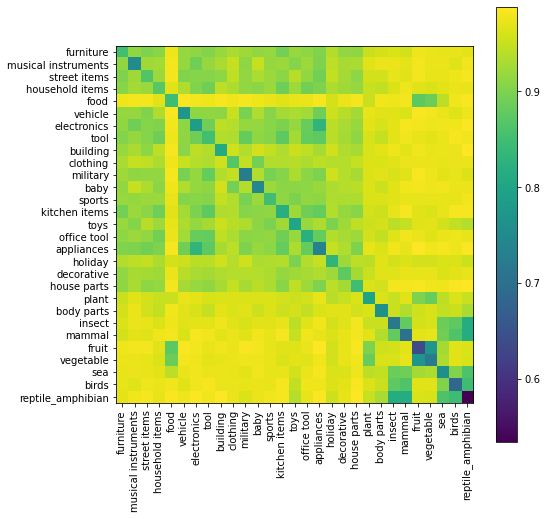

In [11]:
#categories=df_all.groupby('category')['category'].count()

categoryNames=df_all[df_all['domain']=='nonliving']['category'].unique().tolist()
categoryNames.extend(
    df_all[df_all['domain']=='living']['category'].unique().tolist())


FeatMtx=(df_all.iloc[:,4:]!=0).to_numpy()

CatDistMtx=categorical_dist(FeatMtx,
                            categorylabels=df_all['category'],
                            categorynames=categoryNames)

plt.figure(figsize=(8,8))
plt.imshow(CatDistMtx)
locs,labels=plt.yticks(list(range(0,len(categoryNames))),
                       labels=categoryNames)
locs,labels=plt.xticks(list(range(0,len(categoryNames))),
                       labels=categoryNames,rotation=90)
plt.colorbar()

let's define categorical distinctiveness as the average cosine distances between categories over the average distances within each categories

In [12]:
def category_distinctiveness(Mtx):
    n=Mtx.shape
    msk=np.eye(n[0])
    Dg=np.mean(Mtx.flatten()[msk.flatten()==1])
    nonDg=np.mean(Mtx.flatten()[msk.flatten()==0])
    return nonDg/Dg

print('category distinctiveness = {}'.format(category_distinctiveness(CatDistMtx)))

CatDistMtx=categorical_dist(FeatMtx,
                            categorylabels=df_all['domain'],
                            categorynames=['living','nonliving'])
print('domain distinctiveness = {}'.format(category_distinctiveness(CatDistMtx)))


category distinctiveness = 1.2081808071910705
domain distinctiveness = 1.0719800267673578


### Data cleaning -- excluding uncommon features

The dimension of the feature space is way too high (>5500)! Most of the features are rarely selected by the mTurkers and rarely shared across objects, which means they are mostly unused. Dropping these features can make computation much simpler, but dropping too much features may lead to insufficient description. We need to understand whether dropping features will lead to a loss of information

In [47]:
FeatMtx_raw=(df_all.iloc[:,4:]).to_numpy()

exclude_thr1=[0,5,10,15,20] #shared categories
exclude_thr2=[0,5,10,15,20,25,30,35,40,45,50] #number of responses

optMtx=np.zeros((len(exclude_thr1),len(exclude_thr2)))
featnumberMtx=np.zeros((len(exclude_thr1),len(exclude_thr2)))

for i in range(len(exclude_thr1)):
    for j in range(len(exclude_thr2)):
        tmp1=(FeatMtx_raw!=0).sum(axis=0)>=exclude_thr1[i]
        tmp2=FeatMtx_raw.sum(axis=0)>=exclude_thr2[j]
        tmpind = tmp1&tmp2
        FeatMtx = FeatMtx_raw[:,tmpind]!=0
        CatFeatDistMtx=categorical_dist(FeatMtx,
                                        categorylabels=df_all['category'],
                                        categorynames=categoryNames)
        optMtx[i,j]=category_distinctiveness(CatFeatDistMtx)
        featnumberMtx[i,j]=FeatMtx.shape[1]

minimum distinctiveness 1.20818080719107
maximum distinctiveness 1.3757909555475245


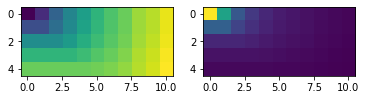

In [48]:
g,Ax=plt.subplots(1,2)
Ax[0].imshow(optMtx)
Ax[1].imshow(featnumberMtx)

print('minimum distinctiveness {}'.format(np.min(optMtx)) )
print('maximum distinctiveness {}'.format(np.max(optMtx)) )

For simplicity, we will exclude features that are extremely uncommon, e.g., those with less than 50 responses or shared by less than 10 different objects. 
We also exclude objects that have less than 5 features

In [13]:
#exclude categories ('reptile_amphibian','baby') whose sizes are less than 10% the size of the largest category ('tool')
df_all2=df_all[ ~df_all['category'].isin(['reptile_amphibian','baby']) ]

tmp1=(df_all2.iloc[:,4:]!=0).sum(axis=0)>=5
tmp2=df_all2.iloc[:,4:].sum(axis=0)>=25
tmpind=(tmp1&tmp2).to_numpy()

tmpind=np.concatenate(([1,1,1,1],tmpind*1))

df_hifreq=pd.DataFrame.copy(df_all2)
df_hifreq=df_hifreq.iloc[:,tmpind!=0]
print(df_hifreq.shape)

#exclude objects that have very few features
tmp1=(df_hifreq.iloc[:,4:]!=0).sum(axis=1)>5 
print(sum(tmp1))
print(df_hifreq['concept'][tmp1==0].to_list())

df_hifreq=df_hifreq[tmp1]
print(df_hifreq.shape)


categoryNames=df_hifreq[df_hifreq['domain']=='nonliving']['category'].unique().tolist()
categoryNames.extend(
    df_hifreq[df_hifreq['domain']=='living']['category'].unique().tolist())

domainNames=['living','nonliving']
CatDistMtx=categorical_dist((df_hifreq.iloc[:,4:]!=0).to_numpy(),
                          categorylabels=df_hifreq['category'],
                          categorynames=categoryNames)
print('category distinctiveness after dropping features {}'.format(
    category_distinctiveness(CatDistMtx) ) )

CatDistMtx=categorical_dist((df_hifreq.iloc[:,4:]!=0).to_numpy(),
                          categorylabels=df_hifreq['domain'],
                          categorynames=domainNames)
print('domain distinctiveness after dropping features {}'.format(
    category_distinctiveness(CatDistMtx) ) )

(981, 655)
979
['nose', 'poison']
(979, 655)
category distinctiveness after dropping features 1.3052576841832146
domain distinctiveness after dropping features 1.1188959131100995


## explore similarity between features, and similarity betweeen objects

### we first tried t-SNE to reduce the dimension of the dataset

from Wikipedia:
t-distributed stochastic neighbor embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. It is based on Stochastic Neighbor Embedding originally developed by Sam Roweis and Geoffrey Hinton,where Laurens van der Maaten proposed the t-distributed variant. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects are assigned a higher probability while dissimilar points are assigned a lower probability. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map. While the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this can be changed as appropriate.

In [15]:
X=df_hifreq.iloc[:,4:].to_numpy() #this is the feature matrix (object x features)

X_embedded = TSNE(n_components=2).fit_transform(X!=0)
df_tsnevis=pd.DataFrame()
df_tsnevis['category']=df_hifreq['category']
df_tsnevis['domain']=df_hifreq['domain']
df_tsnevis['dim1']=X_embedded[:,0]
df_tsnevis['dim2']=X_embedded[:,1]

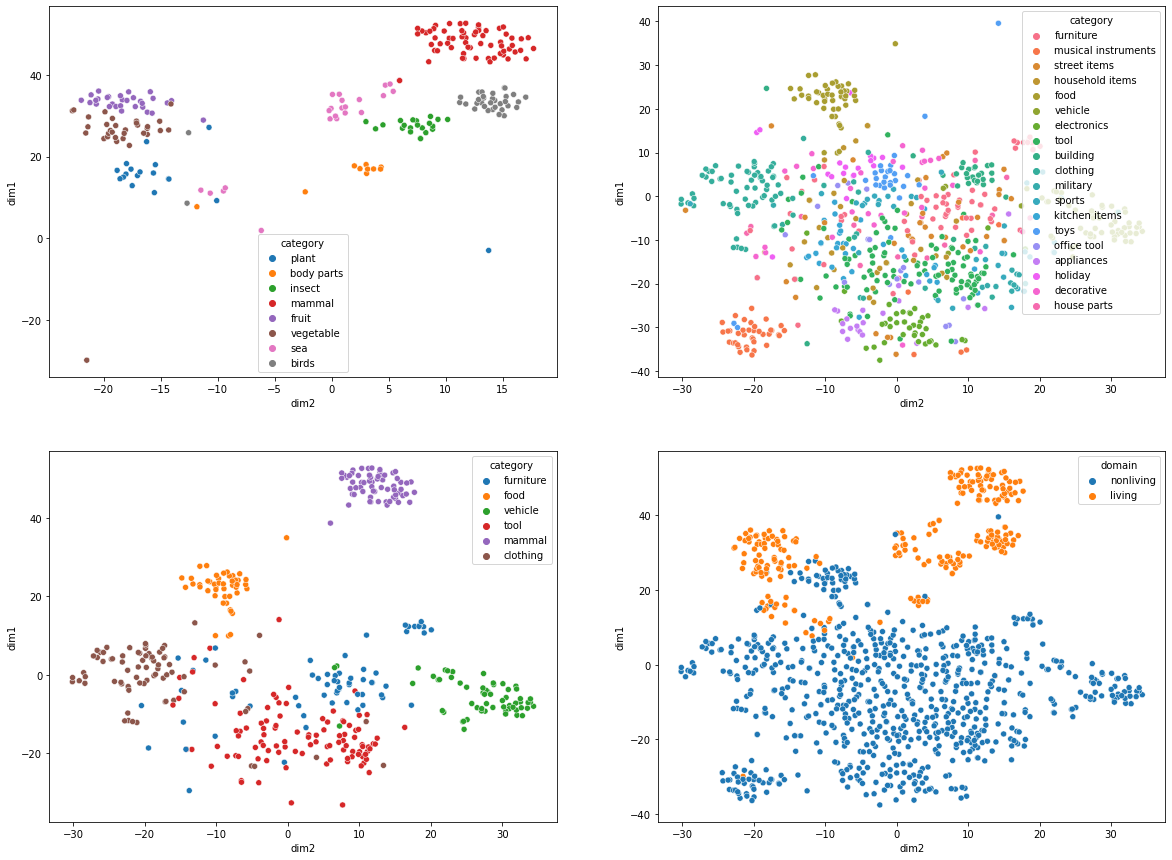

In [16]:
g,Ax=plt.subplots(2,2)

visdat=df_tsnevis[df_tsnevis['domain']=='living']
sns.scatterplot(ax=Ax[0,0],x='dim2', y='dim1', data=visdat, hue='category')

visdat=df_tsnevis[df_tsnevis['domain']=='nonliving']
sns.scatterplot(ax=Ax[0,1],x='dim2', y='dim1', data=visdat, hue='category')

visdat=df_tsnevis[df_tsnevis['category'].isin(['tool','clothing','furniture','mammal','vehicle','food'])]
sns.scatterplot(ax=Ax[1,0],x='dim2', y='dim1', data=visdat, hue='category')

visdat=df_tsnevis
sns.scatterplot(ax=Ax[1,1],x='dim2', y='dim1', data=visdat, hue='domain')

g.set_size_inches(20,15)

##  now see if we can transform the sparse feature coding into a lower dimension space 

### method 1: using Restricted Boltzmann Machine

https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine

In [17]:
from sklearn.neural_network import BernoulliRBM

X=(df_hifreq.iloc[:,4:]!=0).to_numpy() #this is the feature matrix (object x features)
RBMmdl=BernoulliRBM(n_components=75)
RBMmdl.fit(X!=0)

h_RBM=RBMmdl.transform(X)

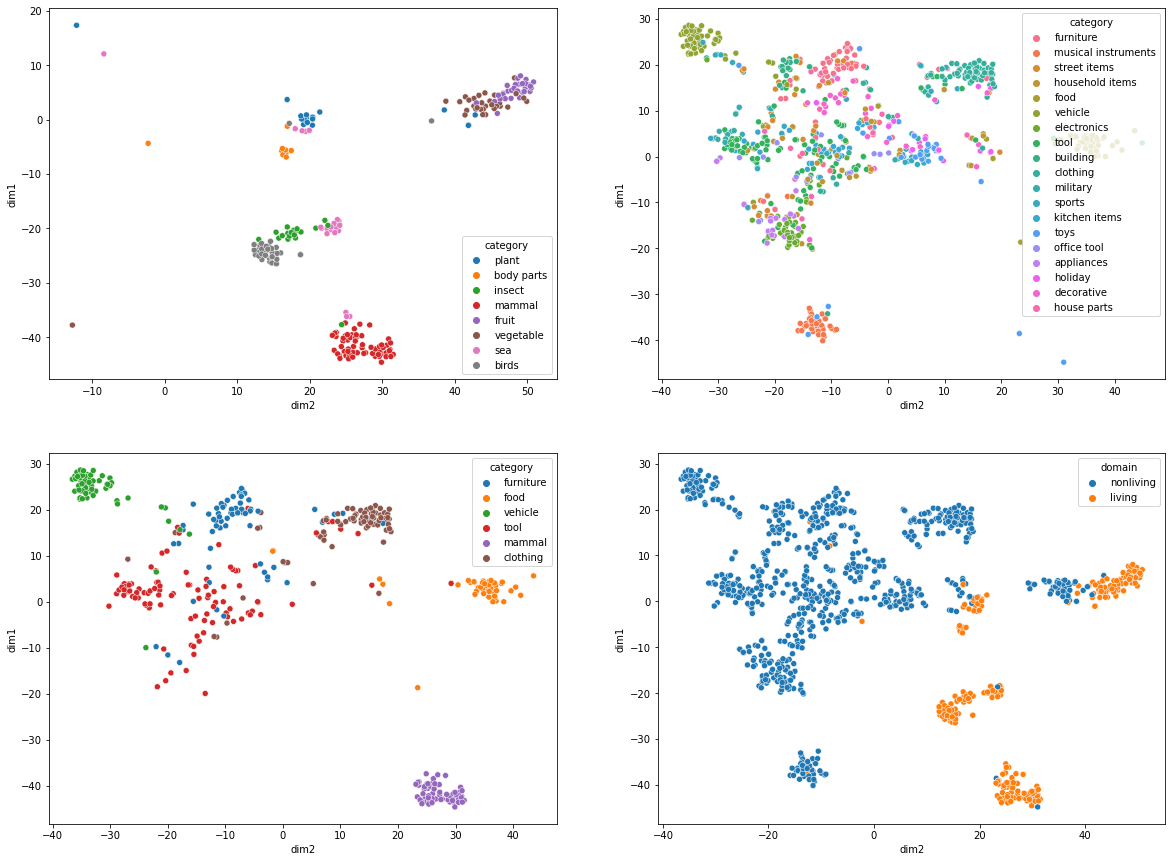

In [18]:
X_embedded = TSNE(n_components=2).fit_transform(h_RBM)

df_tsnevis=pd.DataFrame()
df_tsnevis['category']=df_hifreq['category']
df_tsnevis['domain']=df_hifreq['domain']
df_tsnevis['dim1']=X_embedded[:,0]
df_tsnevis['dim2']=X_embedded[:,1]

g,Ax=plt.subplots(2,2)

visdat=df_tsnevis[df_tsnevis['domain']=='living']
sns.scatterplot(ax=Ax[0,0],x='dim2', y='dim1', data=visdat, hue='category')

visdat=df_tsnevis[df_tsnevis['domain']=='nonliving']
sns.scatterplot(ax=Ax[0,1],x='dim2', y='dim1', data=visdat, hue='category')

visdat=df_tsnevis[df_tsnevis['category'].isin(['tool','clothing','furniture','mammal','vehicle','food'])]
sns.scatterplot(ax=Ax[1,0],x='dim2', y='dim1', data=visdat, hue='category')

visdat=df_tsnevis
sns.scatterplot(ax=Ax[1,1],x='dim2', y='dim1', data=visdat, hue='domain')

g.set_size_inches(20,15)

category distinctiveness = 3.373140802939644
category distinctiveness = 1.7985440896595224


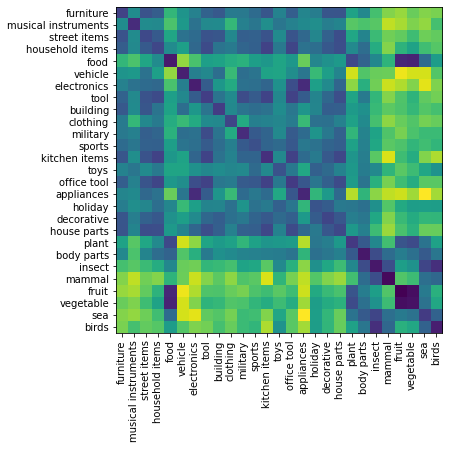

In [20]:
CatDistMtx=categorical_dist(h_RBM, # X_embedded
                          categorylabels=df_hifreq['category'],
                          categorynames=categoryNames)
print('category distinctiveness = {}'.format(
    category_distinctiveness(CatDistMtx) ) )#optMtx[1,5]

plt.figure(figsize=(6,6))
plt.imshow(CatDistMtx)
locs,labels=plt.yticks(list(range(0,len(categoryNames))),
                       labels=categoryNames)
locs,labels=plt.xticks(list(range(0,len(categoryNames))),
                       labels=categoryNames,rotation=90)

CatDistMtx=categorical_dist(h_RBM, # X_embedded
                          categorylabels=df_hifreq['domain'],
                          categorynames=domainNames)
print('category distinctiveness = {}'.format(
    category_distinctiveness(CatDistMtx) ) )#optMtx[1,5]



### method 2: using an auto-encoder

# create a classifier for predicting living / non-living objects

In [21]:
X=(df_hifreq.iloc[:,4:].to_numpy())!=0
y=pd.get_dummies(df_hifreq['domain']).to_numpy()

X_train,X_test,y_train,y_test=sklearn.model_selection.train_test_split(
    X,y,test_size=0.3,random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(685, 651)
(685, 2)
(294, 651)
(294, 2)


### classifier 1: neural network with two hidden layers

In [22]:
clf = sklearn.neural_network.MLPClassifier(solver='adam',hidden_layer_sizes=(75,30),max_iter=500)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(clf.score(X_test,y_test))

0.9761904761904762


In [23]:
Ws=clf.coefs_
bs=clf.intercepts_

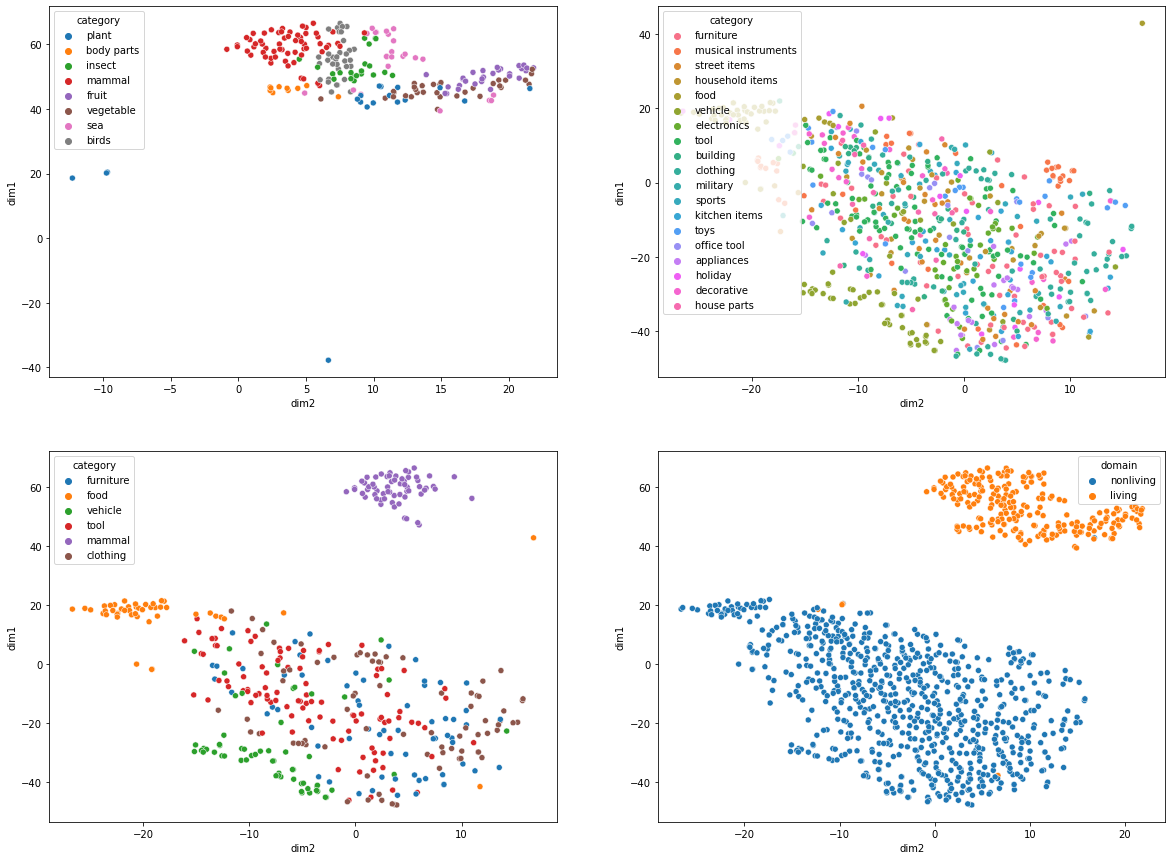

In [24]:
#hiddenA=( (X!=0)@Ws[0]+bs[0] ) @ Ws[1] + bs[1] # this would be the second hidden layer
hiddenA=( X@Ws[0]+bs[0] )*(( X@Ws[0]+bs[0] )>0) # hidden_layer1 activation (ReLU)

X_embedded = TSNE(n_components=2).fit_transform(hiddenA)

df_tsnevis=pd.DataFrame()
df_tsnevis['category']=df_hifreq['category']
df_tsnevis['domain']=df_hifreq['domain']
df_tsnevis['dim1']=X_embedded[:,0]
df_tsnevis['dim2']=X_embedded[:,1]

g,Ax=plt.subplots(2,2)

visdat=df_tsnevis[df_tsnevis['domain']=='living']
sns.scatterplot(ax=Ax[0,0],x='dim2', y='dim1', data=visdat, hue='category')

visdat=df_tsnevis[df_tsnevis['domain']=='nonliving']
sns.scatterplot(ax=Ax[0,1],x='dim2', y='dim1', data=visdat, hue='category')

visdat=df_tsnevis[df_tsnevis['category'].isin(['tool','clothing','furniture','mammal','vehicle','food'])]
sns.scatterplot(ax=Ax[1,0],x='dim2', y='dim1', data=visdat, hue='category')

visdat=df_tsnevis
sns.scatterplot(ax=Ax[1,1],x='dim2', y='dim1', data=visdat, hue='domain')

g.set_size_inches(20,15)

category distinctiveness  3.9413808234726524
domain distinctiveness  6.1349529042520174


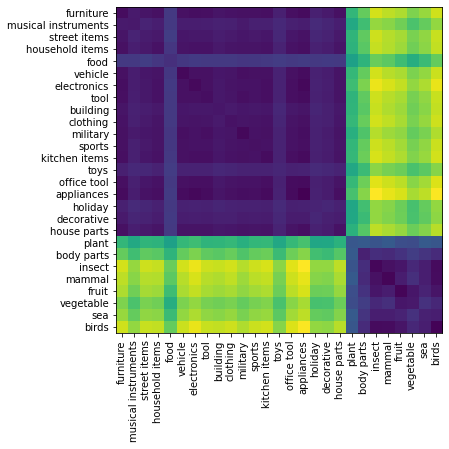

In [25]:
CatDistMtx=categorical_dist(hiddenA, # X_embedded
                          categorylabels=df_hifreq['category'],
                          categorynames=categoryNames)
print('category distinctiveness  {}'.format(
    category_distinctiveness(CatDistMtx) ) )#optMtx[1,5]

plt.figure(figsize=(6,6))
plt.imshow(CatDistMtx)
locs,labels=plt.yticks(list(range(0,len(categoryNames))),
                       labels=categoryNames)
locs,labels=plt.xticks(list(range(0,len(categoryNames))),
                       labels=categoryNames,rotation=90)

CatDistMtx=categorical_dist(hiddenA, # X_embedded
                          categorylabels=df_hifreq['domain'],
                          categorynames=domainNames)
print('domain distinctiveness  {}'.format(
    category_distinctiveness(CatDistMtx) ) )



### classifier 2: feature vector is first fed to a Restricted Boltzmann machine to reduce dimension, and the output vector is fed into a neural network with one hidden layer. Note the number of hidden units of the restricted Boltzmann machine matches the number of units in the first layer of classifier 1

In [26]:
RBMmdl=BernoulliRBM(n_components=75)
RBMmdl.fit(X_train)
X_train_lowdim=RBMmdl.transform(X_train)


clf2 = sklearn.neural_network.MLPClassifier(solver='adam',hidden_layer_sizes=(30,),max_iter=600)
clf2.fit(X_train_lowdim,y_train)

X_test_lowdim=RBMmdl.transform(X_test)
y_pred=clf2.predict(X_test_lowdim)

print(clf2.score(X_test_lowdim,y_test))




0.9727891156462585


category distinctiveness  3.9214851357862237
domain distinctiveness  2.1137024376691027


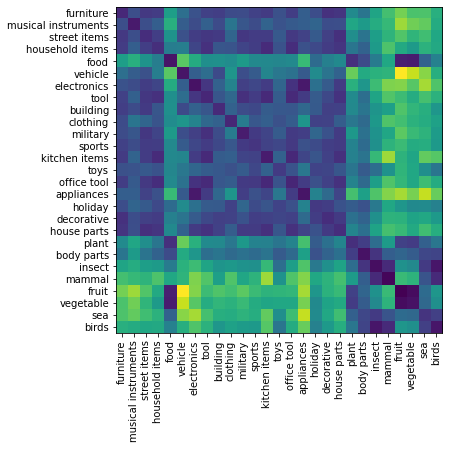

In [27]:
CatDistMtx=categorical_dist(RBMmdl.transform(X), # 
                          categorylabels=df_hifreq['category'],
                          categorynames=categoryNames)
print('category distinctiveness  {}'.format(
    category_distinctiveness(CatDistMtx) ) )#optMtx[1,5]

plt.figure(figsize=(6,6))
plt.imshow(CatDistMtx)
locs,labels=plt.yticks(list(range(0,len(categoryNames))),
                       labels=categoryNames)
locs,labels=plt.xticks(list(range(0,len(categoryNames))),
                       labels=categoryNames,rotation=90)

CatDistMtx=categorical_dist(RBMmdl.transform(X), # 
                          categorylabels=df_hifreq['domain'],
                          categorynames=domainNames)
print('domain distinctiveness  {}'.format(
    category_distinctiveness(CatDistMtx) ) )

### classifier 3: feature vector is first fed to a Restricted Boltzmann machine to reduce dimension, and the output vector is fed into a second Restricted Boltzmann machine. The hidden activation of the second RBM is fed into a logistic regression.  Note the number of hidden units of the restricted Boltzmann machine matches the number of units in the first layer of classifier 1

In [28]:
RBMmdl=BernoulliRBM(n_components=75)
RBMmdl.fit(X_train)
X_train_lowdim=RBMmdl.transform(X_train)

RBMmdl2=BernoulliRBM(n_components=30)
RBMmdl2.fit(X_train_lowdim)
X_train_lowdim_2=RBMmdl2.transform(X_train_lowdim)

clf3=sklearn.linear_model.LogisticRegression(random_state=0)
clf3.fit(X_train_lowdim_2, y_train[:,0])

X_test_lowdim=RBMmdl.transform(X_test)
X_test_lowdim_2=RBMmdl2.transform(X_test_lowdim)
y_pred=clf3.predict(X_test_lowdim_2)

print(clf3.score(X_test_lowdim_2,y_test[:,0]))

0.9625850340136054


category distinctiveness  4.461461682987959
domain distinctiveness  2.466261293313745


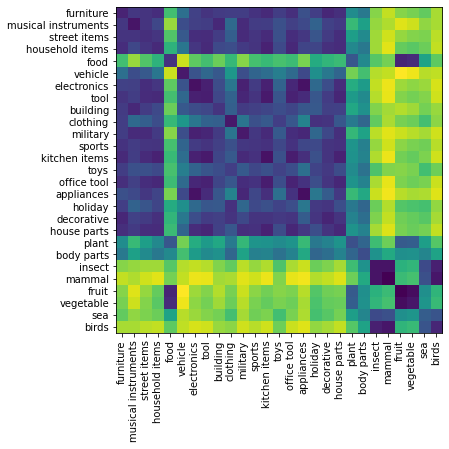

In [29]:
CatDistMtx=categorical_dist(RBMmdl2.transform(RBMmdl.transform(X)), # 
                          categorylabels=df_hifreq['category'],
                          categorynames=categoryNames)
print('category distinctiveness  {}'.format(
    category_distinctiveness(CatDistMtx) ) )#optMtx[1,5]

plt.figure(figsize=(6,6))
plt.imshow(CatDistMtx)
locs,labels=plt.yticks(list(range(0,len(categoryNames))),
                       labels=categoryNames)
locs,labels=plt.xticks(list(range(0,len(categoryNames))),
                       labels=categoryNames,rotation=90)

CatDistMtx=categorical_dist(RBMmdl2.transform(RBMmdl.transform(X)), # 
                          categorylabels=df_hifreq['domain'],
                          categorynames=domainNames)
print('domain distinctiveness  {}'.format(
    category_distinctiveness(CatDistMtx) ) )